# Consent Session Fuzzy Detection using Pre-trained BERT
This notebook loads a Hugging Face model trained for vagueness detection to classify each sub-task comment as either 'Vague' or 'Clear', providing a semantic alternative to rule-based matching.

In [1]:
!pip install transformers -q

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [4]:
def parse_consent_session_xml(xml_file_path):
    with open(xml_file_path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "xml")

    session_name = soup.find("taskName").text.strip()
    overall_score = soup.find("result").text.strip()
    items = soup.find_all("item")

    subtask_names = [item.find("taskName").text.strip() for item in items]
    subtask_scores = [float(item.find("result").text.strip()) for item in items]
    comments = [item.find("comment").text.strip() for item in items]

    return session_name, overall_score, subtask_names, subtask_scores, comments

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_id = "Slomb/Ambig_Question"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)

nlp = pipeline("text-classification", model=model, tokenizer=tokenizer)


Device set to use cpu


In [6]:
texts = [
    "Did he do it?",
    "Did Peter win the game?",
    "What time is the meeting?",
    "Is it raining?"
]

results = nlp(texts)
for text, result in zip(texts, results):
    print(f"'{text}' --> {result['label']} ({result['score']:.2f})")


'Did he do it?' --> AMBIG (0.90)
'Did Peter win the game?' --> CLEAR (0.89)
'What time is the meeting?' --> AMBIG (0.73)
'Is it raining?' --> AMBIG (0.89)


In [7]:
def visualize_scores(session_name, subtask_names, subtask_scores, fuzzy_flags):
    avg_score = sum(subtask_scores) / (len(subtask_scores) * 5) * 100
    plt.figure(figsize=(6, 4))
    bars = plt.bar(subtask_names, subtask_scores, color=['orange' if fuzzy else 'steelblue' for fuzzy in fuzzy_flags])
    plt.ylim(0, 5)
    plt.ylabel("Input Clarity Rating (0–5)")
    plt.xlabel("Sub-task Name")
    plt.title(f"Sub-task Scores in '{session_name}'\n(Average Score: {avg_score:.1f}%)")

    for i, bar in enumerate(bars):
        score = subtask_scores[i]
        label = f"{score:.1f}" + ("*" if fuzzy_flags[i] else "")
        plt.text(bar.get_x() + bar.get_width() / 2, score + 0.1, label, ha='center')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    print(f"Detected {sum(fuzzy_flags)} vague input(s) out of {len(fuzzy_flags)}.")

In [8]:

def classify_vagueness_and_score(comments):
    fuzzy_flags = []
    clarity_scores = []
    for text in comments:
        inputs = tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        vague_prob = probs[0][1].item()
        fuzzy_flags.append(vague_prob > 0.5)
        clarity_scores.append(round((1 - vague_prob) * 5, 2))  # Scale from 0–5
    return fuzzy_flags, clarity_scores


In [9]:
from bs4 import BeautifulSoup
with open("consent_session_with_comments.xml", "r", encoding="utf-8") as f:
    soup = BeautifulSoup(f, "xml")
print(soup.prettify()[:500]) 

<?xml version="1.0" encoding="utf-8"?>
<task>
 <result>
  65%
 </result>
 <taskName>
  Telehealth Consent Session
 </taskName>
 <secordTask>
  <item>
   <taskName>
    Age Declaration
   </taskName>
   <result>
    3
   </result>
   <comment>
    I’m almost 18
   </comment>
  </item>
  <item>
   <taskName>
    State Location Confirmation
   </taskName>
   <result>
    4
   </result>
   <comment>
    Somewhere in Missouri
   </comment>
  </item>
  <item>
   <taskName>
    Health Issue Description


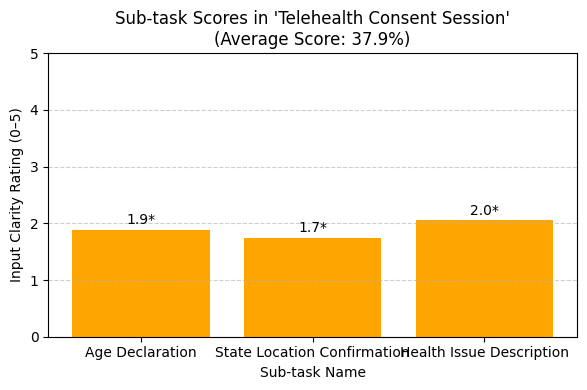

Detected 3 vague input(s) out of 3.


In [10]:

xml_path = "consent_session_with_comments.xml"

session_name, overall_score, subtask_names, subtask_scores_original, comments = parse_consent_session_xml(xml_path)
fuzzy_flags, clarity_scores = classify_vagueness_and_score(comments)
visualize_scores(session_name, subtask_names, clarity_scores, fuzzy_flags)


In [12]:
def plot_heatmap_clarity_scores(subtask_names, clarity_scores):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    df = pd.DataFrame({
        "Sub-task": subtask_names,
        "Clarity Score": clarity_scores
    })

    plt.figure(figsize=(6, 2))
    sns.heatmap(
        df[["Clarity Score"]].T,
        annot=True,
        fmt=".1f",
        cmap="YlOrRd_r",
        cbar=True,
        xticklabels=df["Sub-task"],
        yticklabels=["Input Clarity"]
    )
    plt.title("Input Clarity Heatmap for Consent Sub-tasks")
    plt.tight_layout()
    plt.show()


In [15]:
!pip install pandas seaborn

  Using cached pandas-2.3.1-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.1-cp310-cp310-win_amd64.whl (11.3 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----------------------------- 1/4 [tzdata]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 [p

C:\Users\skybl\AppData\Local\Temp\ipykernel_15112\3760848767.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


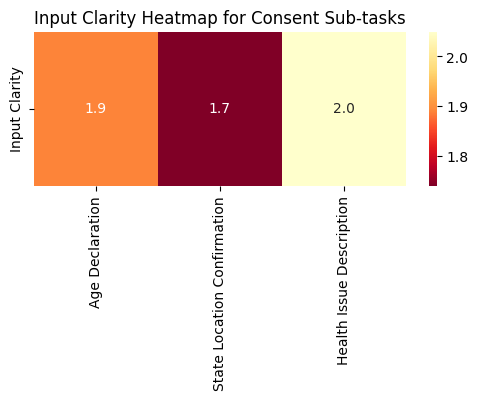

In [16]:
plot_heatmap_clarity_scores(subtask_names, clarity_scores)